In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from imblearn.over_sampling import SMOTE


In [7]:
df = pd.read_csv('/content/loan_approval_dataset.csv')
print(df.columns)

Index(['loan_id', ' no_of_dependents', ' education', ' self_employed',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')


In [8]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64


In [9]:
if df.isnull().sum().any():
    # For numerical columns, fill with median
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    # For categorical columns, fill with mode
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])

    print("Missing values handled")


Cleaned column names:
Index(['loan_id', 'no_of_dependents', 'education', 'self_employed',
       'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
       'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value', 'loan_status'],
      dtype='object')


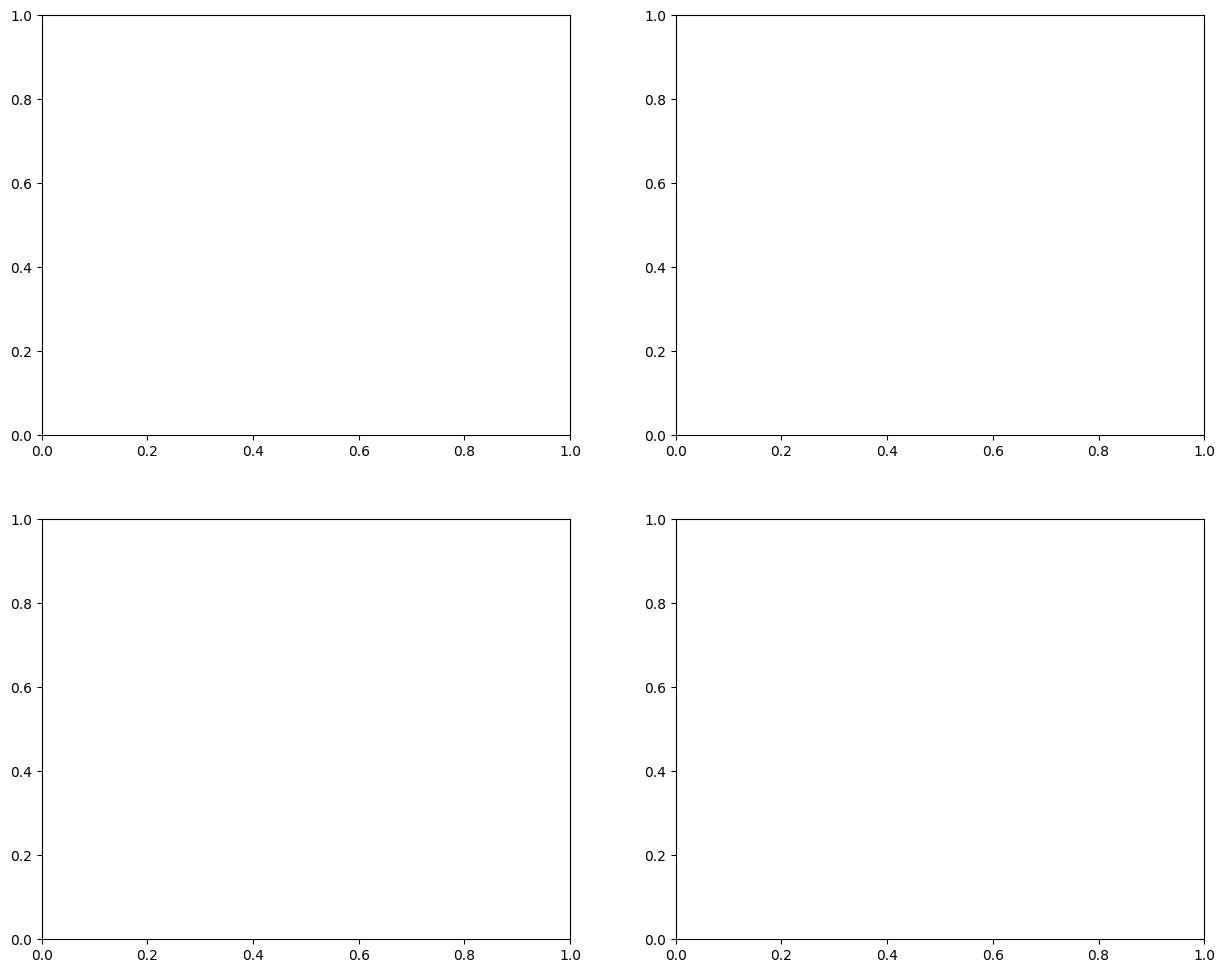

In [12]:
df.columns = df.columns.str.strip()
print("\nCleaned column names:")
print(df.columns)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))


In [14]:
status_counts = df['loan_status'].value_counts()
axes[0, 0].bar(range(len(status_counts)), status_counts.values,
               color=['red', 'green'], alpha=0.7)
axes[0, 0].set_title('Loan Status Distribution')
axes[0, 0].set_xlabel('Loan Status')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticks(range(len(status_counts)))
axes[0, 0].set_xticklabels(status_counts.index)

[Text(0, 0, ' Approved'), Text(1, 0, ' Rejected')]

In [15]:
# Distribution of income by loan status
sns.boxplot(x='loan_status', y='income_annum', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Income Distribution by Loan Status')

# Distribution of CIBIL score by loan status
sns.boxplot(x='loan_status', y='cibil_score', data=df, ax=axes[1, 0])
axes[1, 0].set_title('CIBIL Score Distribution by Loan Status')

Text(0.5, 1.0, 'CIBIL Score Distribution by Loan Status')

In [16]:
status_numeric = df['loan_status'].map({status_counts.index[0]: 0, status_counts.index[1]: 1})
scatter = axes[1, 1].scatter(df['loan_amount'], df['income_annum'],
                            c=status_numeric, cmap='coolwarm', alpha=0.6)
axes[1, 1].set_title('Loan Amount vs Income (Color: Loan Status)')
axes[1, 1].set_xlabel('Loan Amount')
axes[1, 1].set_ylabel('Income')
plt.colorbar(scatter, ax=axes[1, 1])

plt.tight_layout()
plt.show()

/tmp/ipython-input-3259873607.py:7: UserWarning: Adding colorbar to a different Figure <Figure size 1500x1200 with 5 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter, ax=axes[1, 1])


<Figure size 640x480 with 0 Axes>

In [18]:
print("\nCategorical variables before encoding:")
cat_cols = ['education', 'self_employed']
print(cat_cols)


Categorical variables before encoding:
['education', 'self_employed']


In [19]:
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"{col} encoded: {le.classes_}")

education encoded: [' Graduate' ' Not Graduate']
self_employed encoded: [' No' ' Yes']


In [20]:
target_values = df['loan_status'].unique()
print(f"\nTarget values: {target_values}")
df['loan_status_encoded'] = df['loan_status'].map({target_values[0]: 0, target_values[1]: 1})
y = df['loan_status_encoded']

print(f"Target distribution: {np.bincount(y)}")
print(f"Class 0: {target_values[0]}, Class 1: {target_values[1]}")

X = df.drop(['loan_id', 'loan_status', 'loan_status_encoded'], axis=1)

print(f"\nFeatures: {X.columns.tolist()}")
print(f"Target distribution: {np.bincount(y)}")


Target values: [' Approved' ' Rejected']
Target distribution: [2656 1613]
Class 0:  Approved, Class 1:  Rejected

Features: ['no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
Target distribution: [2656 1613]


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Class distribution in training set: {np.bincount(y_train)}")
print(f"Class distribution in testing set: {np.bincount(y_test)}")


Training set size: 3415
Testing set size: 854
Class distribution in training set: [2125 1290]
Class distribution in testing set: [531 323]


In [23]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
print("\n" + "="*60)
print("Training models on IMBALANCED data")
print("="*60)

models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc:.4f}")



Training models on IMBALANCED data

Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.9356
Precision: 0.9061
Recall: 0.9257
F1-Score: 0.9158
ROC-AUC: 0.9748

Training Decision Tree...
Decision Tree Results:
Accuracy: 0.9731
Precision: 0.9747
Recall: 0.9536
F1-Score: 0.9640
ROC-AUC: 0.9692

Training Random Forest...
Random Forest Results:
Accuracy: 0.9813
Precision: 0.9904
Recall: 0.9598
F1-Score: 0.9748
ROC-AUC: 0.9953



Applying SMOTE to handle class imbalance
After SMOTE - Training set size: 4250
After SMOTE - Class distribution: [2125 2125]

Training Logistic Regression with SMOTE...
Logistic Regression with SMOTE Results:
Accuracy: 0.9321
Precision: 0.9077
Recall: 0.9133
F1-Score: 0.9105
ROC-AUC: 0.9746

Training Decision Tree with SMOTE...
Decision Tree with SMOTE Results:
Accuracy: 0.9742
Precision: 0.9748
Recall: 0.9567
F1-Score: 0.9656
ROC-AUC: 0.9708

Training Random Forest with SMOTE...
Random Forest with SMOTE Results:
Accuracy: 0.9813
Precision: 0.9842
Recall: 0.9659
F1-Score: 0.9750
ROC-AUC: 0.9979

Comparison: With vs Without SMOTE
                     Accuracy (No SMOTE)  Precision (No SMOTE)  \
Logistic Regression               0.9356                0.9061   
Decision Tree                     0.9731                0.9747   
Random Forest                     0.9813                0.9904   

                     Recall (No SMOTE)  F1 (No SMOTE)  Accuracy (SMOTE)  \
Logistic Regression   

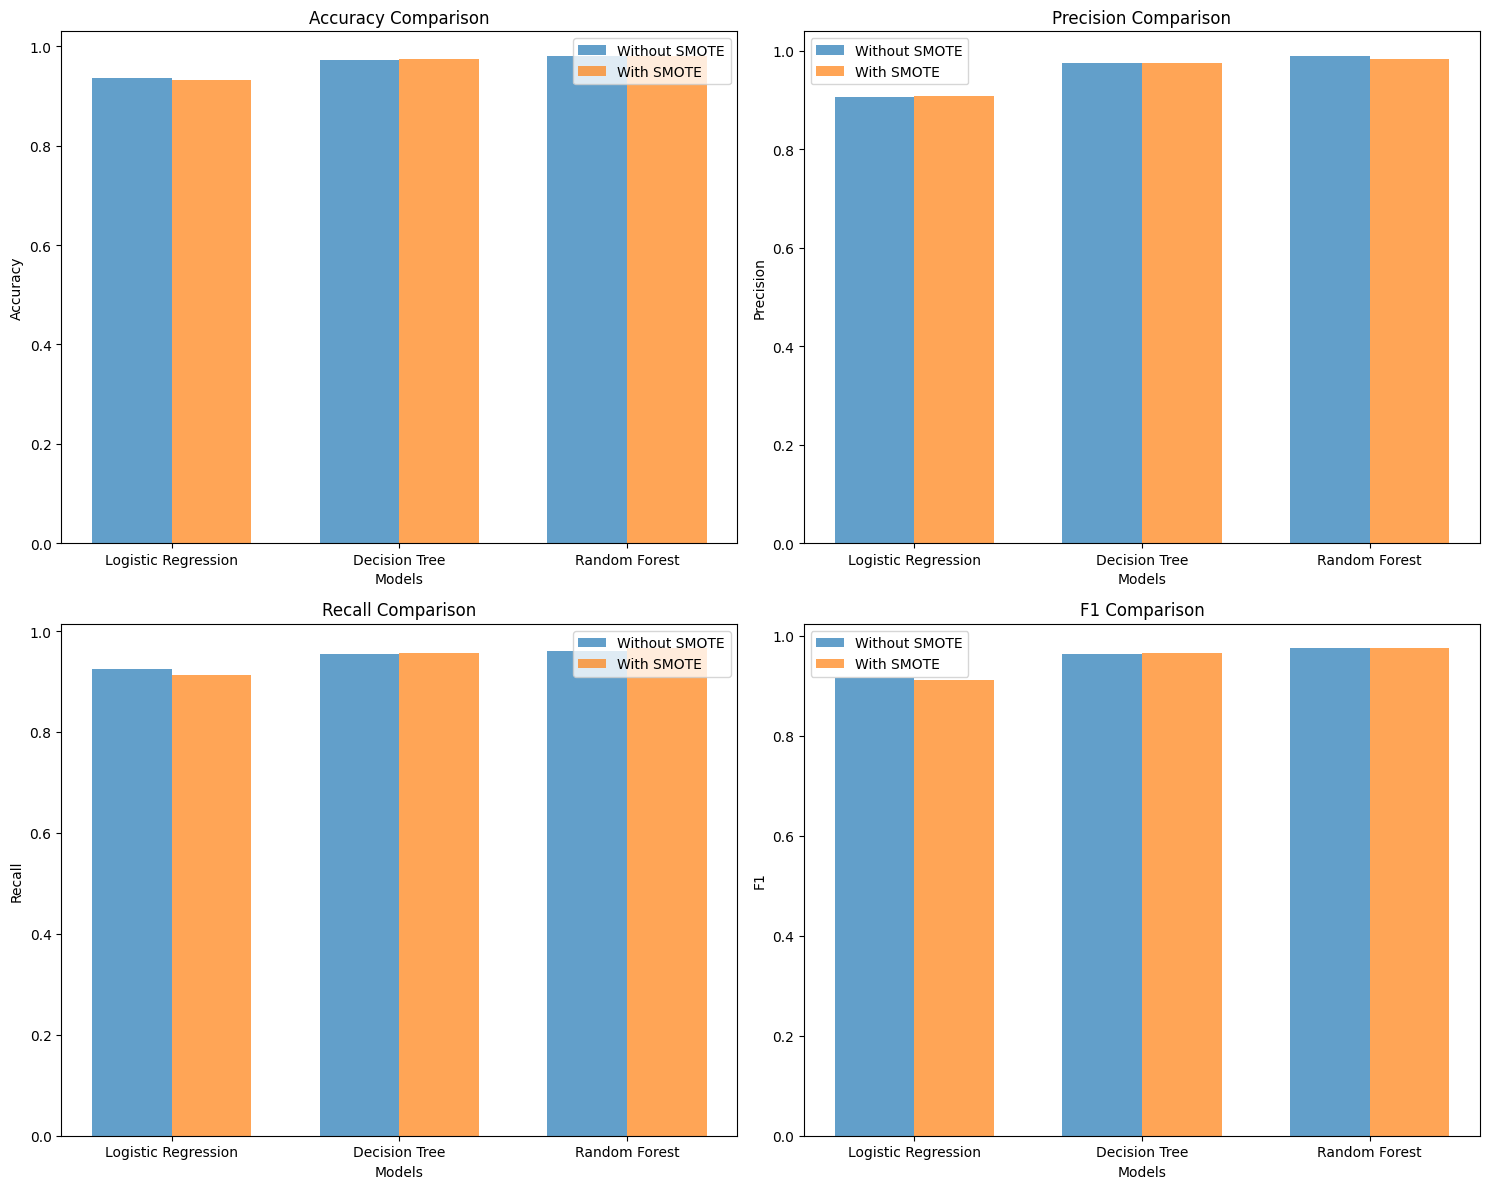

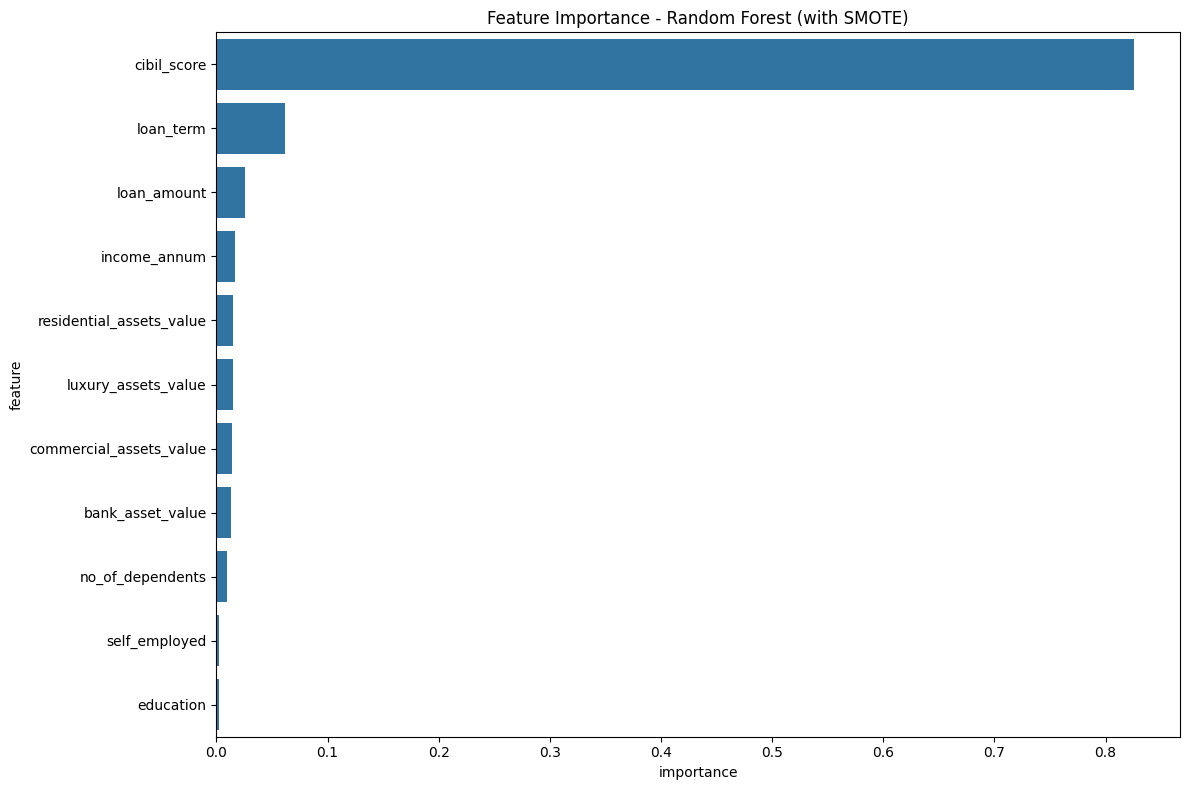


Top 5 most important features:
                    feature  importance
6               cibil_score    0.825712
5                 loan_term    0.061613
4               loan_amount    0.025355
3              income_annum    0.016907
7  residential_assets_value    0.014980

Sample Predictions on Test Data
  True_Status Predicted_Status  Probability_Approved  Correct
0    Rejected         Rejected                  0.98     True
1    Rejected         Rejected                  0.96     True
2    Rejected         Rejected                  0.99     True
3    Approved         Approved                  0.02     True
4    Approved         Approved                  0.03     True
5    Approved         Approved                  0.00     True
6    Approved         Approved                  0.00     True
7    Approved         Approved                  0.02     True
8    Rejected         Rejected                  1.00     True
9    Approved         Approved                  0.00     True

Sample accur

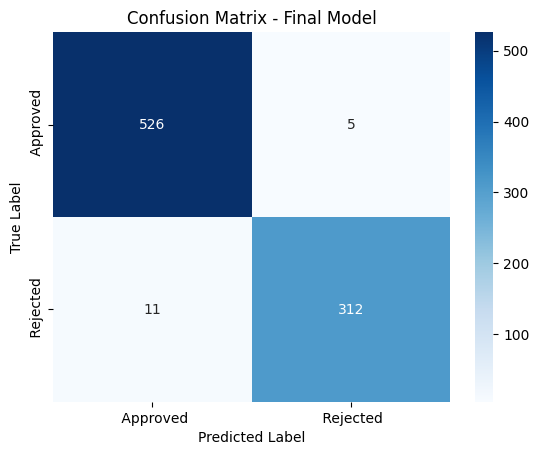

ROC-AUC Score: 0.9979


In [28]:
# 10. BONUS: Apply SMOTE to handle class imbalance
print("\n" + "="*60)
print("Applying SMOTE to handle class imbalance")
print("="*60)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE - Training set size: {X_train_smote.shape[0]}")
print(f"After SMOTE - Class distribution: {np.bincount(y_train_smote)}")

# Train models on balanced data
results_smote = {}

for name, model in models.items():
    print(f"\nTraining {name} with SMOTE...")
    # Create new instance to avoid overwriting
    if name == 'Logistic Regression':
        model_smote = LogisticRegression(random_state=42)
    elif name == 'Decision Tree':
        model_smote = DecisionTreeClassifier(random_state=42)
    else:
        model_smote = RandomForestClassifier(random_state=42, n_jobs=-1)

    model_smote.fit(X_train_smote, y_train_smote)
    y_pred = model_smote.predict(X_test_scaled)
    y_prob = model_smote.predict_proba(X_test_scaled)[:, 1] if hasattr(model_smote, 'predict_proba') else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    results_smote[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'model': model_smote
    }

    print(f"{name} with SMOTE Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc:.4f}")

# 11. Compare results
print("\n" + "="*60)
print("Comparison: With vs Without SMOTE")
print("="*60)

comparison = pd.DataFrame()

for model_name in models.keys():
    without_smote = results[model_name]
    with_smote = results_smote[model_name]

    comparison.loc[model_name, 'Accuracy (No SMOTE)'] = without_smote['accuracy']
    comparison.loc[model_name, 'Precision (No SMOTE)'] = without_smote['precision']
    comparison.loc[model_name, 'Recall (No SMOTE)'] = without_smote['recall']
    comparison.loc[model_name, 'F1 (No SMOTE)'] = without_smote['f1']

    comparison.loc[model_name, 'Accuracy (SMOTE)'] = with_smote['accuracy']
    comparison.loc[model_name, 'Precision (SMOTE)'] = with_smote['precision']
    comparison.loc[model_name, 'Recall (SMOTE)'] = with_smote['recall']
    comparison.loc[model_name, 'F1 (SMOTE)'] = with_smote['f1']

print(comparison.round(4))

# 12. Visualize comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
models_list = list(models.keys())

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, metric in enumerate(metrics):
    without_values = [results[model][metric.lower()] for model in models_list]
    with_values = [results_smote[model][metric.lower()] for model in models_list]

    x = np.arange(len(models_list))
    width = 0.35

    axes[i].bar(x - width/2, without_values, width, label='Without SMOTE', alpha=0.7)
    axes[i].bar(x + width/2, with_values, width, label='With SMOTE', alpha=0.7)

    axes[i].set_xlabel('Models')
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(models_list)
    axes[i].legend()

plt.tight_layout()
plt.show()

# 13. Feature importance for the best model
best_model = results_smote['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance - Random Forest (with SMOTE)')
plt.tight_layout()
plt.show()

print("\nTop 5 most important features:")
print(feature_importance.head(5))

# 14. Make predictions on new data
print("\n" + "="*60)
print("Sample Predictions on Test Data")
print("="*60)

# Get some sample predictions
sample_idx = np.random.choice(len(X_test), 10, replace=False)
sample_X = X_test.iloc[sample_idx]
sample_y_true = y_test.iloc[sample_idx]
sample_y_pred = best_model.predict(X_test_scaled[sample_idx])
sample_y_prob = best_model.predict_proba(X_test_scaled[sample_idx])[:, 1]

results_sample = pd.DataFrame({
    'True_Status': [target_values[val] for val in sample_y_true.values],
    'Predicted_Status': [target_values[val] for val in sample_y_pred],
    'Probability_Approved': sample_y_prob,
    'Correct': sample_y_true.values == sample_y_pred
})

print(results_sample)
print(f"\nSample accuracy: {results_sample['Correct'].mean():.2%}")

# 15. Final model evaluation
print("\n" + "="*60)
print("Final Model Evaluation - Random Forest with SMOTE")
print("="*60)

final_predictions = best_model.predict(X_test_scaled)
final_probabilities = best_model.predict_proba(X_test_scaled)[:, 1]

print("Classification Report:")
print(classification_report(y_test, final_predictions,
                           target_names=[target_values[0], target_values[1]]))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, final_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[target_values[0], target_values[1]],
            yticklabels=[target_values[0], target_values[1]])
plt.title('Confusion Matrix - Final Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"ROC-AUC Score: {roc_auc_score(y_test, final_probabilities):.4f}")